In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib as pl
import urllib
import os

from shapely.geometry import Point
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

from __future__ import print_function
import os
import pandas as pd
import pylab as pl
import statsmodels.api as st
import scipy as sp 
from scipy import stats
import seaborn  as sns
import statsmodels.formula.api as smf
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble  import RandomForestRegressor as rfr

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

import ast

# PART I Data gathering and wrangling

## 1. Collect the school related data (10 points)

### 1.1 Collect School SAT data (5 points)

In [6]:
# reading SAT data

sat_data = pd.read_csv('https://data.cityofnewyork.us/resource/734v-jeq5.csv')
sat_data.shape

(478, 6)

In [7]:
sat_data = sat_data.rename(columns={'sat_critical_reading_avg_score':'SATread',
                                    'sat_math_avg_score':'SATmath',
                                    'sat_writing_avg_score':'SATwrite'})

In [8]:
sat_data[["SATread", "SATmath", "SATwrite"]] = sat_data[["SATread", "SATmath", "SATwrite"]].apply(pd.to_numeric, errors='coerce')
sat_data.head()

,dbn,num_of_sat_test_takers,SATread,SATmath,SATwrite,school_name
0,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES
1,01M448,91,383.0,423.0,366.0,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2,01M450,70,377.0,402.0,370.0,EAST SIDE COMMUNITY SCHOOL
3,01M458,7,414.0,401.0,359.0,FORSYTH SATELLITE ACADEMY
4,01M509,44,390.0,433.0,384.0,MARTA VALLE HIGH SCHOOL


In [9]:
sat_data['SATall'] = (sat_data['SATread'] + 
                      sat_data['SATmath'] +
                      sat_data['SATwrite']) / 3
sat_data.head()

,dbn,num_of_sat_test_takers,SATread,SATmath,SATwrite,school_name,SATall
0,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.000000
1,01M448,91,383.0,423.0,366.0,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,390.666667
2,01M450,70,377.0,402.0,370.0,EAST SIDE COMMUNITY SCHOOL,383.000000
3,01M458,7,414.0,401.0,359.0,FORSYTH SATELLITE ACADEMY,391.333333
4,01M509,44,390.0,433.0,384.0,MARTA VALLE HIGH SCHOOL,402.333333


In [10]:
sat = sat_data.drop(['num_of_sat_test_takers', 'SATread', 'SATwrite', 'school_name'], axis=1)
sat.head()

,dbn,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


### 1.2 Collect School Crime data (5 points)

In [11]:
#downloading school crime data

!curl https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD > 'safety.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2471k    0 2471k    0     0  3092k      0 --:--:-- --:--:-- --:--:-- 3092k


In [12]:
# move the data
!mv safety.csv $PUIDATA

#reading data
safety_data = pd.read_csv(os.getenv("PUIDATA") + "/" + 'safety.csv')
safety_data.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', 'Location Code',
       'Address', 'Borough', 'Geographical District Code', 'Register',
       'Building Name', '# Schools', 'Schools in Building', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude', 'Community Board',
       'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [13]:
safety_data.shape

(6310, 34)

In [14]:
safety = safety_data.drop(['Building Code', 'Location Name', 'Location Code',
                           'Address', 'Borough', 'Geographical District Code', 'Register',
                           'Building Name', '# Schools', 'Schools in Building', 'ENGroupA', 'RangeA',
                           'Borough Name', 'Postcode', 'Community Board',
                           'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'], axis=1)

In [15]:
safety.head()

,School Year,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,2013-14,15K001,0.0,2.0,1.0,1.0,0.0,0.86,3.26,5.55,2.17,1.29,40.649042,-74.012289
1,2013-14,17K002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
2,2013-14,75K141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
3,2013-14,84K704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
4,2013-14,NaN,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583


In [16]:
safety_clean = safety.fillna(0) #filling nans with zeros
print(safety_clean.shape)

(6310, 14)


In [17]:
# inspecting types of crimes

safety_clean.describe()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
count,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000,6310.000000
mean,0.282250,1.099208,1.865610,0.710301,0.503962,0.281992,1.092247,1.849452,0.707637,0.500242,40.581680,-73.639038
std,0.805189,2.557436,5.365985,1.672241,1.393973,0.399735,1.635429,3.471469,1.014561,0.748008,2.509188,4.551178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-74.244118
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.672762,-73.961476
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.270000,0.900000,1.230000,0.640000,0.440000,40.725725,-73.922171
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.380000,1.650000,2.380000,0.980000,0.750000,40.818232,-73.881224
max,15.000000,29.000000,84.000000,22.000000,20.000000,3.330000,13.000000,34.860000,9.200000,7.170000,40.903553,0.000000


The highest variance is found in the number/average of non criminal incidents and the lowest is in the number/average of major crimes. This suggests that non crimal crimes is the most common type of crimes and that most schools witness either a very low number of major crimes or do not witness it at all. The plots below present a visual support for this note.

Text(0.5,1,'Fig.2: Distribution of average number of non-criminal incidents (not grouped by school)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


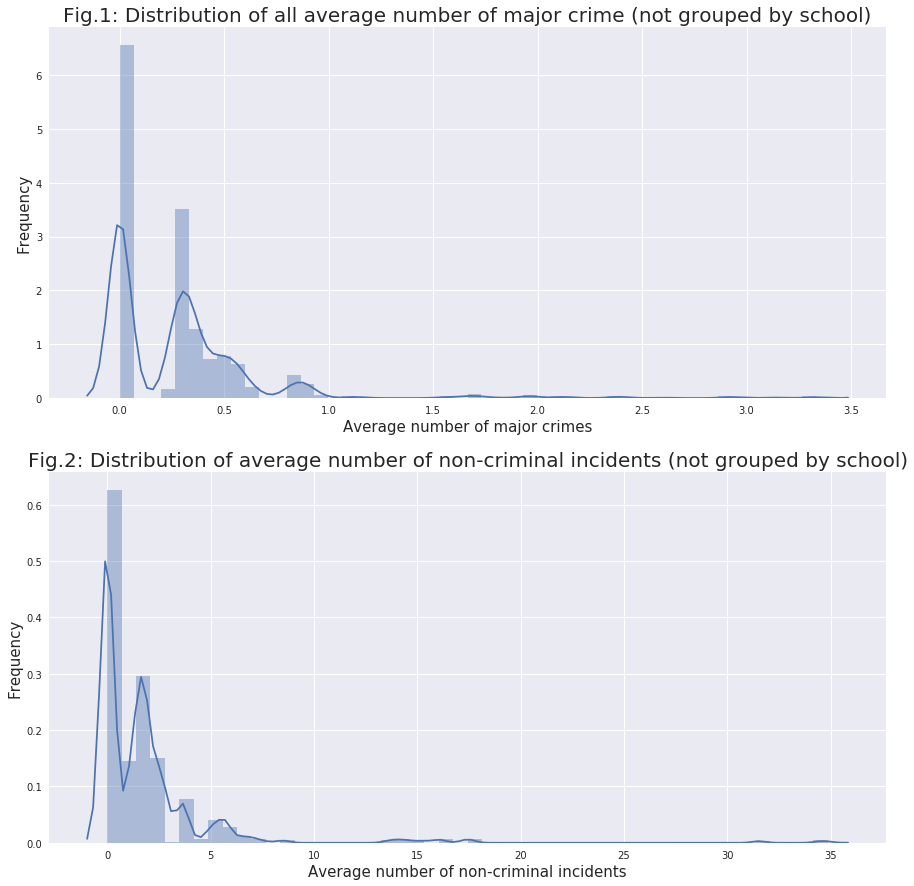

In [18]:
#plotting distribution of crime incidents among schools for highest and lowest crime types.

fig = pl.figure(figsize=(15,15)) 


ax = fig.add_subplot(211)

plot = sns.distplot(safety_clean['AvgOfMajor N'], ax=ax)
ax.set_xlabel("Average number of major crimes", size=15)
ax.set_ylabel("Frequency", size=15)
ax.set_title("Fig.1: Distribution of all average number of major crime (not grouped by school)", size=20)

ax = fig.add_subplot(212)

plot = sns.distplot(safety_clean['AvgOfNoCrim N'], ax=ax)
ax.set_xlabel("Average number of non-criminal incidents", size=15)
ax.set_ylabel("Frequency", size=15)
ax.set_title("Fig.2: Distribution of average number of non-criminal incidents (not grouped by school)", size=20)

### Distributions of the average number of major crimes and non-criminal incidents in NYC schools between 2010 and 2016. 

In general, The most frequent number of incidents from both types is 0. The average number of major crimes in most schools are less than 1, whereas the range of number of non-criminal incidents was between zero to 5.  

Note that figures 1 and 2 report the average incidents in schools, in each year seperately. For the 5-year aggregate average number of incidents in each school, see figures 3 and 4.

In [19]:
# removing longitude and latitude to preserve its values and add them later
safety_gr_ = safety_clean.drop(['Latitude', 'Longitude'], axis=1)

DBN value represents each school building. The dataframe contains data about each school in different years. Since we're only interested in the aggregated average for each school and not yearly change, I'll group the data by dbn.

Note that some DBNs contain more than one school, which is reported in the '# of schools' column. Since the individual properties of every school in the building wasn't in the dataset, then grouping them will not further increase the margin of error. 

In [29]:
#grouping data by school and reporting the mean average numebr of crimes through out the 5 year period

safety_gr = safety_gr_.groupby('DBN').mean().reset_index()
safety_gr.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
0,0,1.011976,3.891218,7.422156,2.409182,1.883234,0.650689,2.551687,4.702645,1.607974,1.192914
1,01M015,0.666667,0.666667,0.666667,1.000000,0.333333,0.343333,0.833333,1.370000,0.713333,0.366667
2,01M019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,01M020,0.666667,2.000000,3.000000,1.333333,1.333333,0.306667,1.183333,1.773333,0.790000,0.543333
4,01M034,0.000000,1.333333,1.333333,0.333333,1.000000,0.296667,1.023333,1.380000,0.720000,0.473333


In [30]:
print ('number of observations in the original dataset is,', len(safety_gr_.DBN.unique()))
print ('number of observations in the grouped dataset is,', len(safety_gr.DBN.unique()))
print ('Number of unique school locations is,', len(safety_data.Longitude.unique()))

number of observations in the original dataset is, 1932
number of observations in the grouped dataset is, 1932
Number of unique school locations is, 1192


The number of unique building values didn't change. However, several buildings with missing DBN number were grouped and are currently present as zero. This new point is unrealisticly high and can cause an error during analysis. So it will be dropped.
Also note that the number of locations is significantly less than the number of schools. This means that some schools are in the same location.

In [31]:
safety_gr = safety_gr[safety_gr.DBN != 0]
safety_gr.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
1,01M015,0.666667,0.666667,0.666667,1.000000,0.333333,0.343333,0.833333,1.370000,0.713333,0.366667
2,01M019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,01M020,0.666667,2.000000,3.000000,1.333333,1.333333,0.306667,1.183333,1.773333,0.790000,0.543333
4,01M034,0.000000,1.333333,1.333333,0.333333,1.000000,0.296667,1.023333,1.380000,0.720000,0.473333
5,01M063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5,1,'Fig.4: Distribution of average number of non-criminal incidents (grouped by school)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


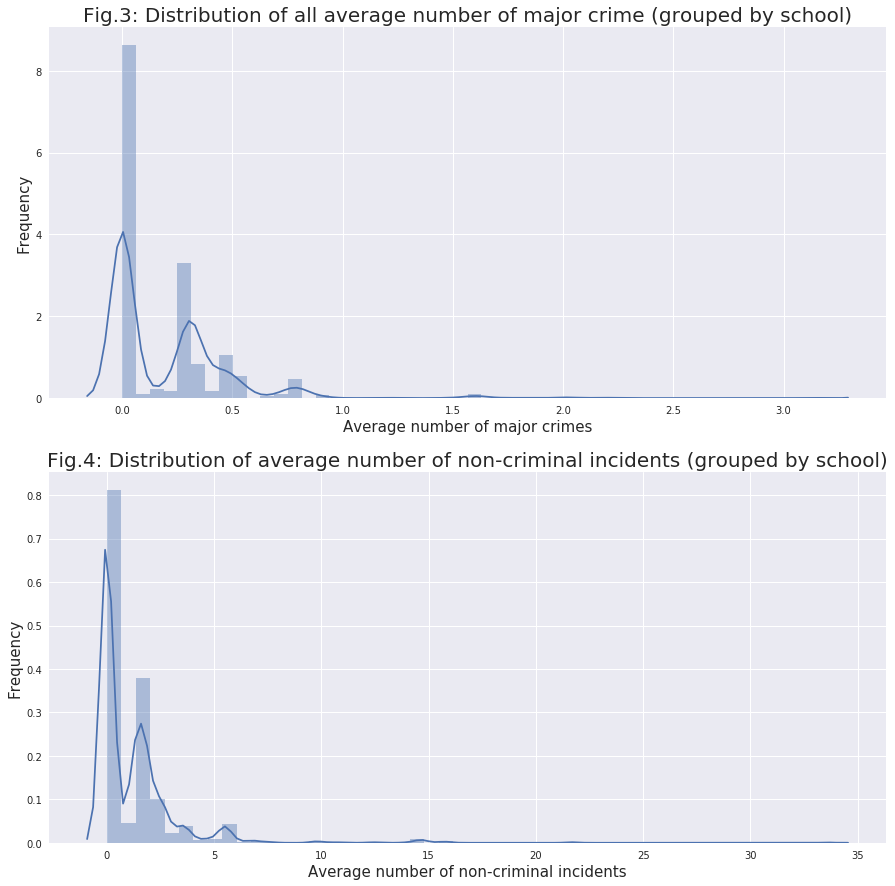

In [32]:
# plotting data grouped by school


fig = pl.figure(figsize=(15,15)) 


ax = fig.add_subplot(211)

plot = sns.distplot(safety_gr['AvgOfMajor N'], ax=ax)
ax.set_xlabel("Average number of major crimes", size=15)
ax.set_ylabel("Frequency", size=15)
ax.set_title("Fig.3: Distribution of all average number of major crime (grouped by school)", size=20)

ax = fig.add_subplot(212)

plot = sns.distplot(safety_gr['AvgOfNoCrim N'], ax=ax)
ax.set_xlabel("Average number of non-criminal incidents", size=15)
ax.set_ylabel("Frequency", size=15)
ax.set_title("Fig.4: Distribution of average number of non-criminal incidents (grouped by school)", size=20)

### Distributions of the average number of major crimes and non-criminal incidents by school, between 2010 and 2016. 
The overwhelming majority of schools witnessed zero incidents. Grouping data has removed several outliers in bith types and narrowed the range of non-criminal incidents, whose majority of observations now ends at approximately 5.5.

# 2. Merge school crime and SAT data (10 points)

### 2.1 Merge the SAT and the crime in school data based on the school identifier. (4 points)

In [33]:
#adding SAT scores data
merged = pd.merge(safety_gr, sat_data, left_on='DBN', right_on='dbn', how='left')
merged.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,dbn,num_of_sat_test_takers,SATread,SATmath,SATwrite,school_name,SATall
0,01M015,0.666667,0.666667,0.666667,1.000000,0.333333,0.343333,0.833333,1.370000,0.713333,0.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,0.666667,2.000000,3.000000,1.333333,1.333333,0.306667,1.183333,1.773333,0.790000,0.543333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,0.000000,1.333333,1.333333,0.333333,1.000000,0.296667,1.023333,1.380000,0.720000,0.473333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course. hints (4 points)

In [34]:
merged = merged[merged.DBN != 0] #removing unknown dbns
merged = merged.fillna(0)
merged.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,dbn,num_of_sat_test_takers,SATread,SATmath,SATwrite,school_name,SATall
0,01M015,0.666667,0.666667,0.666667,1.000000,0.333333,0.343333,0.833333,1.370000,0.713333,0.366667,0,0,0.0,0.0,0.0,0,0.0
1,01M019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0.0,0,0.0
2,01M020,0.666667,2.000000,3.000000,1.333333,1.333333,0.306667,1.183333,1.773333,0.790000,0.543333,0,0,0.0,0.0,0.0,0,0.0
3,01M034,0.000000,1.333333,1.333333,0.333333,1.000000,0.296667,1.023333,1.380000,0.720000,0.473333,0,0,0.0,0.0,0.0,0,0.0
4,01M063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0.0,0,0.0


In [35]:
#keeping schools with reported SAT scores only

merged_schools_ = merged[merged.SATall > 0]
merged_schools_.head(3)

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,dbn,num_of_sat_test_takers,SATread,SATmath,SATwrite,school_name,SATall
13,01M292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.000000
22,01M448,0.333333,1.333333,3.000000,0.666667,0.333333,0.296667,1.023333,1.380000,0.72,0.473333,01M448,91,383.0,423.0,366.0,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,390.666667
23,01M450,0.333333,3.333333,0.666667,2.000000,0.666667,0.306667,1.183333,1.773333,0.79,0.543333,01M450,70,377.0,402.0,370.0,EAST SIDE COMMUNITY SCHOOL,383.000000


In [37]:
merged_schools_loc = safety_clean.drop(['School Year', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N'], axis=1)

In [39]:
merged_schools = merged_schools_.merge(merged_schools_loc, left_on='DBN', right_on='DBN', how='inner')
merged_schools.head(3)

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,dbn,num_of_sat_test_takers,SATread,SATmath,SATwrite,school_name,SATall,Latitude,Longitude
0,01M292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.0,40.713684,-73.986336
1,01M292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.0,40.713684,-73.986336
2,01M292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.0,40.713684,-73.986336


### 2.3 Count the individual school location: there may be multiple schools in a single building. What could be the implication of this in your analysis? hints (2 points)

In [40]:
print ('Number of buildings in original dataset is,', len(safety['DBN'].unique()))
print ('Number of buildings in original dataset with full location information,', len(safety['Longitude'].unique()))
print(" ")
print ('Number of buildings in grouped dataset is,', len(merged_schools['DBN'].unique()))
print ('Number of buildings in grouped dataset with full location information,', len(merged_schools['Longitude'].unique()))

Number of buildings in original dataset is, 1932
Number of buildings in original dataset with full location information, 1192
 
Number of buildings in grouped dataset is, 413
Number of buildings in grouped dataset with full location information, 258


There are only 413 out of 1931 schools with full information (SAT scores). So we'll only keep those for the rest of the analysis. As previously mentioned, the number of locations are less than DBNs. This suggests that some schools are present in the same locations. This will later affect our visualization and mapping analysis, since information on each school will be averaged and assigned to a single puma. This averaging process will result in information loss and will specifically affect pumas that contain multiple schools in the same location (highly dense areas)

# 3. Visualize the school related data (10 points)

### 3.1 plot the Math SAT score and the average of all SAT scores (the feature you created in Task 1) as a function of two crime statistics (5 points)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


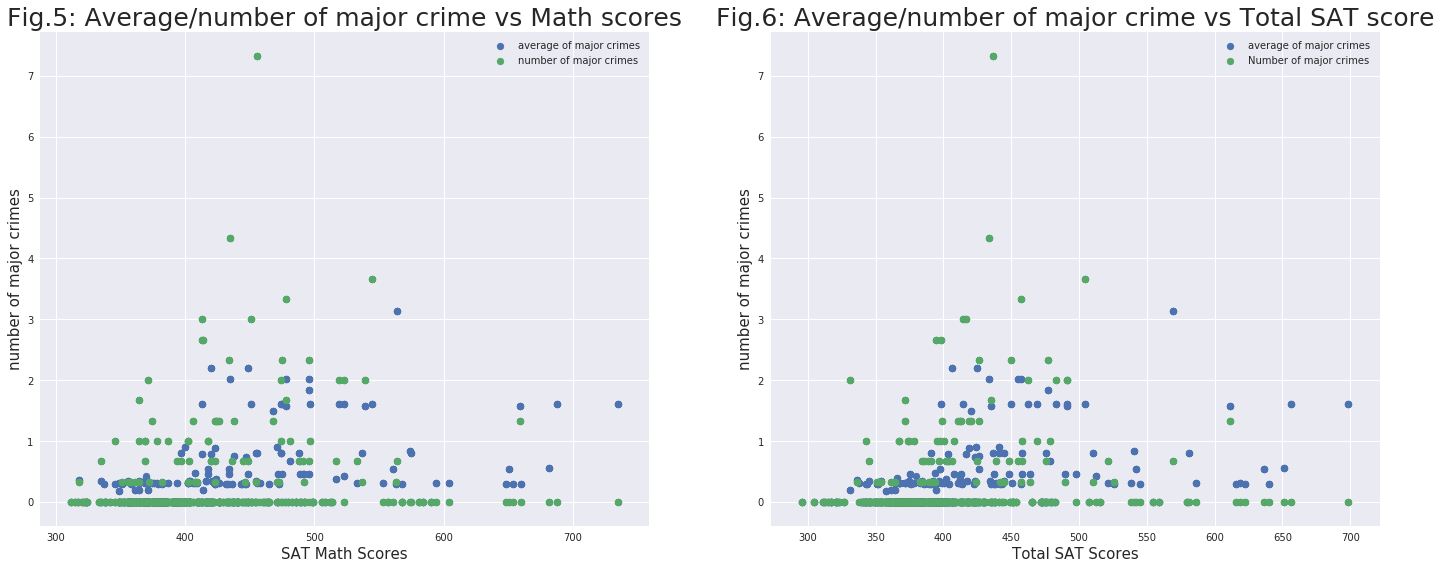

In [42]:
fig = pl.figure(figsize=(24,20)) 
ax = fig.add_subplot(221)

plot = ax.scatter(merged_schools.SATmath, merged_schools['AvgOfMajor N'], label='average of major crimes')
plot = ax.scatter(merged_schools.SATmath, merged_schools['Major N'], label='number of major crimes')
ax.set_ylabel("number of major crimes", size=15)
ax.set_xlabel("SAT Math Scores", size=15)
ax.set_title("Fig.5: Average/number of major crime vs Math scores", size=25)
ax.legend()

ax = fig.add_subplot(222)

plot = ax.scatter(merged_schools.SATall, merged_schools['AvgOfMajor N'], label='average of major crimes')
plot = ax.scatter(merged_schools.SATall, merged_schools['Major N'], label='Number of major crimes')
ax.set_ylabel("number of major crimes", size=15)
ax.set_xlabel("Total SAT Scores", size=15)
ax.set_title("Fig.6: Average/number of major crime vs Total SAT score", size=25)
ax.legend()

The figures above show SAT scores against number and average of major crimes. In both graphs, the number of crimes data are more dispersed, which suggests larger variance. All data point are concentrated in the lower left corner. There is no obvious correlation between either crime values and SAT scores.

## Draft: Exploring distributions

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


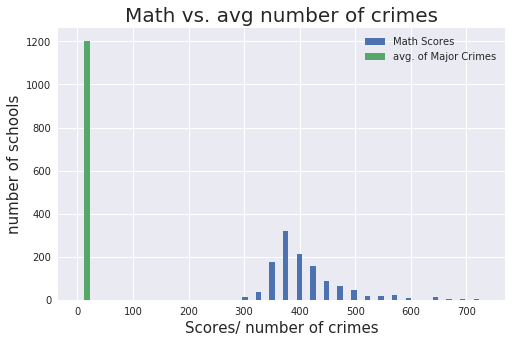

In [43]:
#attempting other plotting methods to find relationships

fig = pl.figure(figsize=(8,5)) 
ax = fig.add_subplot(111)

plot = hist([merged_schools.SATmath, merged_schools['AvgOfMajor N']], 30, label=['Math Scores', 'avg. of Major Crimes'])
ax.set_ylabel("number of schools", size=15)
ax.set_xlabel("Scores/ number of crimes", size=15)
ax.set_title("Math vs. avg number of crimes", size=20)
ax.legend(loc='upper right')

The figure above shows that both data sets are uncomparable and that data standardization is required

# Standardizing data for future analysis

In [45]:
s_merged_ = merged_schools.drop(['DBN', 'num_of_sat_test_takers', 'dbn', 'school_name'], axis=1)

In [47]:
# scores and number of crimes are uncomparable, so we mush first standardize the data

s_merged = (s_merged_ - s_merged_.mean()) / s_merged_.std()
s_merged = s_merged.fillna(0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


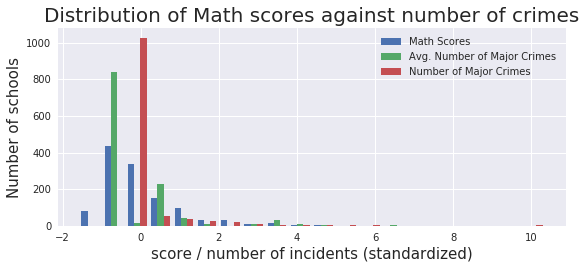

In [54]:
fig = pl.figure(figsize=(20,8)) 
ax = fig.add_subplot(221)

plot = hist([s_merged.SATmath, s_merged['AvgOfMajor N'], s_merged['Major N']], 20,
            label=['Math Scores', 'Avg. Number of Major Crimes', 'Number of Major Crimes'])
ax.set_ylabel("Number of schools", size=15)
ax.set_xlabel("score / number of incidents (standardized)", size=15)
ax.set_title("Distribution of Math scores against number of crimes", size=20)
ax.legend(loc='upper right')

Most schools had an average score of one standard deviation unit less than the mean and so is the average number of major crimes.

### 3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset (5 points)

In [55]:
merged_schools['Coordinates'] = list(zip(merged_schools.Longitude, merged_schools.Latitude))
merged_schools['Coordinates'] = merged_schools['Coordinates'].apply(Point)

In [56]:
gdf_schools = gpd.GeoDataFrame(merged_schools, geometry='Coordinates')
gdf_schools.head(3)

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,...,dbn,num_of_sat_test_takers,SATread,SATmath,SATwrite,school_name,SATall,Latitude,Longitude,Coordinates
0,01M292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.0,40.713684,-73.986336,POINT (-73.98633599999999 40.713684)
1,01M292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.0,40.713684,-73.986336,POINT (-73.98633599999999 40.713684)
2,01M292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,01M292,29,355.0,404.0,363.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,374.0,40.713684,-73.986336,POINT (-73.98633599999999 40.713684)


# 4 Gather Asthma and drugs hospital discharge (10 points)

In [57]:
!curl https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD > 'sparcs.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  972M    0  972M    0     0  5651k      0 --:--:--  0:02:56 --:--:-- 5589k0  164M    0  164M    0     0  5480k      0 --:--:--  0:00:30 --:--:-- 5645k--:--  0:00:34 --:--:-- 5717kk


In [58]:
#create the env variable if missing
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/soa238/PUIdata


In [59]:
# move the data
!mv sparcs.csv $PUIDATA

In [60]:
sparcs_raw = pd.read_csv(os.getenv("PUIDATA") + "/" +'sparcs.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
sparcs_raw.head(3)

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52


In [62]:
sparcs_raw.columns

Index(['Health Service Area', 'Hospital County',
       'Operating Certificate Number', 'Facility ID', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'Discharge Year', 'CCS Diagnosis Code', 'CCS Diagnosis Description',
       'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
       'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

In [63]:
# Dropping unnecassary columns

sparcs_raw_ = sparcs_raw.drop(['Health Service Area', 'Operating Certificate Number', 'Facility Name',
                               'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
                               'Length of Stay', 'Type of Admission', 'Patient Disposition',
                               'Discharge Year', 'CCS Diagnosis Code',
                               'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
                               'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
                               'APR Severity of Illness Code', 'APR Severity of Illness Description',
                               'APR Risk of Mortality', 'APR Medical Surgical Description',
                               'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
                               'Attending Provider License Number',
                               'Operating Provider License Number', 'Other Provider License Number',
                               'Birth Weight', 'Abortion Edit Indicator',
                               'Emergency Department Indicator', 'Total Charges', 'Total Costs'], axis=1)
sparcs_raw_.head()

,Hospital County,Facility ID,CCS Diagnosis Description
0,Allegany,37.0,Pneumonia (except that caused by tuberculosis ...
1,Allegany,37.0,Skin and subcutaneous tissue infections
2,Allegany,37.0,Pneumonia (except that caused by tuberculosis ...
3,Allegany,37.0,Pneumonia (except that caused by tuberculosis ...
4,Allegany,37.0,Pneumonia (except that caused by tuberculosis ...


In [64]:
#Selecting New York City's five Boroughs

nd = sparcs_raw_[(sparcs_raw_['Hospital County'] == 'Manhattan') | 
                 (sparcs_raw_['Hospital County'] == 'Kings') |
                 (sparcs_raw_['Hospital County'] == 'Richmond') |
                 (sparcs_raw_['Hospital County'] == 'Queens') |
                 (sparcs_raw_['Hospital County'] == 'Bronx') | 
                 (sparcs_raw_['Hospital County'] == 'New York')]

print("number of NYC discharges", len(nd.index))

number of NYC discharges 1199520


### 4.2 calculate the fraction of asthma and drug related diagnoses per facility (3 points)

In [65]:
print("number of NYC facilities in the dataset", len(nd['Facility ID'].unique()))

number of NYC facilities in the dataset 61


In [66]:
#Selecting Asthma related diagnosis only

nyca = nd[(nd['CCS Diagnosis Description'] == 'Asthma') | 
         (nd['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)') |
         (nd['CCS Diagnosis Description'] == 'Respiratory distress syndrome')]

print("number of asthma related cases in NYC", len(nyca.index))

number of asthma related cases in NYC 30717


In [67]:
#Selecting drug related diagnosis only 

nycd = nd[(nd['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents') |
         (nd['CCS Diagnosis Description'] == 'Alcohol-related disorders') |
         (nd['CCS Diagnosis Description'] == 'Substance-related disorders')]

print("number of drug related cases in NYC", len(nycd.index))

number of drug related cases in NYC 46336


In [68]:
# dropping unnecassary columns before merging

nyca = nyca.drop(['Hospital County'], axis=1)
nycd = nycd.drop(['Hospital County'], axis=1)

In [69]:
# counting number of asthma and drug incidents in each facility

nyca_count = nyca.groupby(['Facility ID']).size().reset_index(name='asthma_patients_count')
nycd_count = nycd.groupby(['Facility ID']).size().reset_index(name='drug_patients_count')

In [70]:
nyc_ad = nyca_count.merge(nycd_count, left_on='Facility ID', right_on='Facility ID', how='outer')
nyc_ad = nyc_ad.fillna(0)
nyc_ad.head()

,Facility ID,asthma_patients_count,drug_patients_count
0,1165.0,1123.0,1279.0
1,1168.0,580.0,1006.0
2,1169.0,2105.0,323.0
3,1172.0,1826.0,611.0
4,1175.0,25.0,0.0


In [71]:
nyc_ad['asthma_ratio'] = nyc_ad['asthma_patients_count'] / nyc_ad['asthma_patients_count'].sum()
nyc_ad['drug_ratio'] = nyc_ad['drug_patients_count'] / nyc_ad['drug_patients_count'].sum()
nyc_ad.head()

,Facility ID,asthma_patients_count,drug_patients_count,asthma_ratio,drug_ratio
0,1165.0,1123.0,1279.0,0.036560,0.027603
1,1168.0,580.0,1006.0,0.018882,0.021711
2,1169.0,2105.0,323.0,0.068529,0.006971
3,1172.0,1826.0,611.0,0.059446,0.013186
4,1175.0,25.0,0.0,0.000814,0.000000


In [72]:
discharge = nyc_ad.drop(['asthma_patients_count', 'drug_patients_count'], axis=1)
discharge.head()

,Facility ID,asthma_ratio,drug_ratio
0,1165.0,0.036560,0.027603
1,1168.0,0.018882,0.021711
2,1169.0,0.068529,0.006971
3,1172.0,0.059446,0.013186
4,1175.0,0.000814,0.000000


In [73]:
discharge.shape

(57, 3)

## 4.3 find the location of each facility (4 points)

In [74]:
API_URL = 'https://fb55.carto.com/api/v2/sql?q='

def queryCartoDB(query, formatting = 'CSV', source = API_URL):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [75]:
# getting location data from cartoDB

query = '''
select facility_id, facility_latitude, facility_longitude
from fb55.nyc_facilities 
'''
facility_loc = get_data(query)
facility_loc.head(5)

,facility_id,facility_latitude,facility_longitude
0,1320,40.654518,-73.945045
1,6448,40.653175,-73.886772
2,6754,40.689243,-73.956383
3,1206,40.846165,-73.904655
4,1207,40.814503,-73.919029


In [76]:
# Creating dataframe with location before merging
facility_loc_ = pd.DataFrame(facility_loc).astype(float)
facility_loc_.head()

,facility_id,facility_latitude,facility_longitude
0,1320.0,40.654518,-73.945045
1,6448.0,40.653175,-73.886772
2,6754.0,40.689243,-73.956383
3,1206.0,40.846165,-73.904655
4,1207.0,40.814503,-73.919029


In [77]:
# merging data

discharge_merged = discharge.merge(facility_loc_, left_on='Facility ID', right_on='facility_id', how='left') 
discharge_merged

,Facility ID,asthma_ratio,drug_ratio,facility_id,facility_latitude,facility_longitude
0,1165.0,0.036560,0.027603,1165.0,40.857388,-73.846741
1,1168.0,0.018882,0.021711,1168.0,40.894569,-73.861420
2,1169.0,0.068529,0.006971,1169.0,40.879951,-73.880562
3,1172.0,0.059446,0.013186,1172.0,40.817661,-73.924210
4,1175.0,0.000814,0.000000,1175.0,40.847294,-73.844658
5,1176.0,0.029625,0.090146,1176.0,40.853909,-73.891014
6,1178.0,0.043982,0.007273,1178.0,40.843609,-73.911545
7,1185.0,0.008595,0.000367,1185.0,40.840431,-73.848244
8,1186.0,0.008074,0.003777,1186.0,40.880512,-73.881538
9,1286.0,0.029267,0.003993,1286.0,40.655066,-73.912579


In [78]:
#checking data

discharge_merged_ = discharge_merged.dropna() # dropping missing data (see note below)

print ('Number of facilities in SPARCS discharge data is, ', len(discharge['Facility ID'].unique()))
print ('Number of matching facilities in CARTODB data is, ', len(discharge_merged_['facility_id'].unique()))

Number of facilities in SPARCS discharge data is,  57
Number of matching facilities in CARTODB data is,  54


#### Note: 
By comparing the number of facilities in the original discharge data and the merged data, we can notice that three facilities are missing (3 nan values). The locations of these three facilities were not found in the cartoDB data. Since we will not be able to map these three facilities, I dropped them before aggregating data at PUMA level.

# 5. Aggregate at the PUMA level (10 points)

### 5.1 getting PUMA geodata (4 points)

In [79]:
# getting PUMA shapefile

url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /nfshome/soa238/PUIdata/geo_export_a1f5f087-29f5-4f8b-9674-aa515dfb2f44.dbf  
  inflating: /nfshome/soa238/PUIdata/geo_export_a1f5f087-29f5-4f8b-9674-aa515dfb2f44.shp  
  inflating: /nfshome/soa238/PUIdata/geo_export_a1f5f087-29f5-4f8b-9674-aa515dfb2f44.shx  
  inflating: /nfshome/soa238/PUIdata/geo_export_a1f5f087-29f5-4f8b-9674-aa515dfb2f44.prj  


In [80]:
puma = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
                                    "geo_export_05c15ed2-67b1-4879-b48f-e336ecdf6bd7.shp")
puma.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [81]:
puma.crs

{'init': 'epsg:4326'}

In [82]:
# Create a facilities geodataframe

discharge_merged_['Coordinates'] = list(zip(discharge_merged_.facility_longitude, discharge_merged_.facility_latitude))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [83]:
discharge_merged_['Coordinates'] = discharge_merged_['Coordinates'].apply(Point)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [84]:
gdf_discharge = gpd.GeoDataFrame(discharge_merged_, geometry='Coordinates')
gdf_discharge.head()

,Facility ID,asthma_ratio,drug_ratio,facility_id,facility_latitude,facility_longitude,Coordinates
0,1165.0,0.036560,0.027603,1165.0,40.857388,-73.846741,POINT (-73.84674100000001 40.857388)
1,1168.0,0.018882,0.021711,1168.0,40.894569,-73.861420,POINT (-73.86142 40.894569)
2,1169.0,0.068529,0.006971,1169.0,40.879951,-73.880562,POINT (-73.880562 40.879951)
3,1172.0,0.059446,0.013186,1172.0,40.817661,-73.924210,POINT (-73.92421 40.817661)
4,1175.0,0.000814,0.000000,1175.0,40.847294,-73.844658,POINT (-73.844658 40.847294)


In [85]:
gdf_discharge.crs = {'init': 'epsg:4326'}
gdf_discharge.crs

{'init': 'epsg:4326'}

In [86]:
gdf_schools.crs = {'init': 'epsg:4326'}
gdf_schools.crs

{'init': 'epsg:4326'}

In [87]:
#removing schools with missing locations

gdf_schools = gdf_schools[gdf_schools['Latitude'] > 0]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


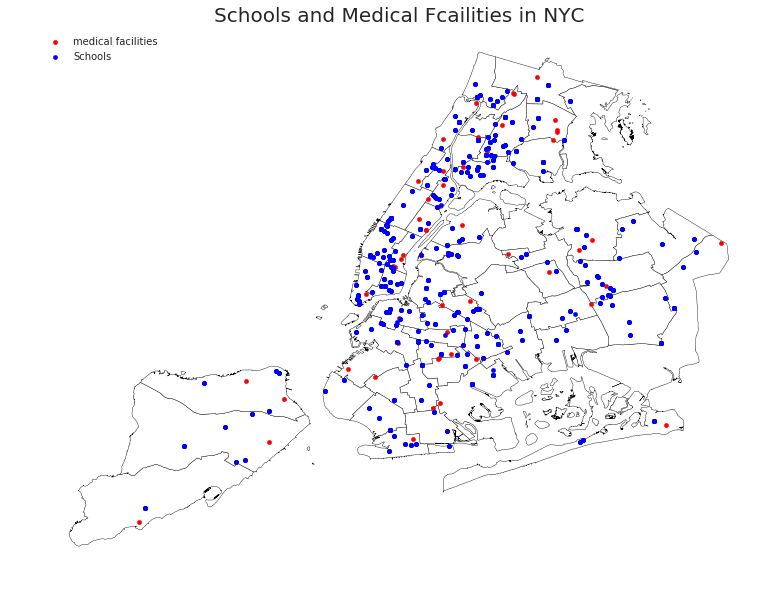

In [88]:
ax = pl.figure(figsize=(13, 10)).add_subplot(111)

puma.plot(ax=ax, color = 'w', scheme='Equal_interval', k=4, edgecolor='k', legend=True, lw=0.4)

gdf_discharge.plot(ax=ax, color = 'red', markersize=20, label='medical facilities')
gdf_schools.plot(ax=ax, color = 'blue', markersize=20, label='Schools')

ax.set_title('Schools and Medical Fcailities in NYC',size=20)
ax.axis('off')
ax.legend(loc='upper left')

This map shows locations of schools and medical facilities in NYC by PUMA. Both Mnhattan and Brooklyn have the highest density of both types of facilities, while Queens and Staten Island have the lowest. Naturally, the number of schools is higher than that The number of hospitals.

## 5.2 join hospital facilities and PUMA data (3 points)

In [89]:
puma_dis = gpd.sjoin(puma, gdf_discharge)

In [90]:
puma_dis.head(2)

,puma,shape_area,shape_leng,geometry,index_right,Facility ID,asthma_ratio,drug_ratio,facility_id,facility_latitude,facility_longitude
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",1,1168.0,0.018882,0.021711,1168.0,40.894569,-73.861420
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",0,1165.0,0.036560,0.027603,1165.0,40.857388,-73.846741


In [91]:
puma_dis_gr = puma_dis.groupby('puma').mean().reset_index()
puma_dis_gr.head()

,puma,shape_area,shape_leng,index_right,Facility ID,asthma_ratio,drug_ratio,facility_id,facility_latitude,facility_longitude
0,3702,1.889860e+08,106050.002302,1.000000,1168.000000,0.018882,0.021711,1168.000000,40.894569,-73.861420
1,3704,1.062129e+08,47970.901277,18.666667,1799.333333,0.018491,0.009884,1799.333333,40.851419,-73.845485
2,3705,1.224951e+08,68657.316149,30.000000,1170.000000,0.014813,0.070852,1170.000000,40.842840,-73.897335
3,3706,4.388687e+07,51799.404183,5.000000,1177.500000,0.038301,0.005374,1177.500000,40.880232,-73.881050
4,3707,4.228113e+07,37347.925798,6.000000,1178.000000,0.043982,0.007273,1178.000000,40.843609,-73.911545


In [92]:
puma_cdis = puma_dis_gr.drop(['shape_area', 'shape_leng', 'index_right', 'Facility ID', 
                              'facility_id', 'facility_latitude', 'facility_longitude'], axis=1)

In [93]:
puma_cdis.head()

,puma,asthma_ratio,drug_ratio
0,3702,0.018882,0.021711
1,3704,0.018491,0.009884
2,3705,0.014813,0.070852
3,3706,0.038301,0.005374
4,3707,0.043982,0.007273


## 5.3 join school data and puma (3 points)

In [94]:
puma_sch = gpd.sjoin(puma, gdf_schools)
puma_sch_gr = puma_sch.groupby('puma').mean().reset_index()
puma_sch_gr.head()

,puma,shape_area,shape_leng,index_right,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATread,SATmath,SATwrite,SATall,Latitude,Longitude
0,3701,9.792852e+07,53227.144461,484.636364,0.030303,0.818182,1.696970,0.454545,0.151515,0.288788,1.321515,2.244242,0.813939,0.544242,424.181818,443.363636,423.545455,430.363636,40.875344,-73.899033
1,3702,1.889860e+08,106050.002302,547.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,379.000000,378.555556,366.666667,374.740741,40.879912,-73.858878
2,3703,2.670137e+08,304071.257466,435.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,390.800000,394.400000,389.000000,391.400000,40.854058,-73.836689
3,3704,1.062129e+08,47970.901277,550.428571,0.000000,1.500000,0.928571,0.785714,0.571429,0.062143,0.237857,0.343571,0.161429,0.107857,413.000000,424.428571,407.500000,414.976190,40.857895,-73.861870
4,3705,1.224951e+08,68657.316149,466.705128,0.192308,1.025641,1.679487,0.448718,0.500000,0.058462,0.218718,0.325000,0.147692,0.100641,373.333333,379.115385,369.756410,374.068376,40.842368,-73.894786


In [95]:
puma_csch = puma_sch_gr.drop(['shape_area', 'shape_leng', 'index_right', 'SATread',
                               'SATwrite', 'Latitude', 'Longitude'], axis=1)

In [96]:
puma_csch.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall
0,3701,0.030303,0.818182,1.696970,0.454545,0.151515,0.288788,1.321515,2.244242,0.813939,0.544242,443.363636,430.363636
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741
2,3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000
3,3704,0.000000,1.500000,0.928571,0.785714,0.571429,0.062143,0.237857,0.343571,0.161429,0.107857,424.428571,414.976190
4,3705,0.192308,1.025641,1.679487,0.448718,0.500000,0.058462,0.218718,0.325000,0.147692,0.100641,379.115385,374.068376


In [97]:
# merging all data

puma_data = puma_csch.merge(puma_cdis, left_on='puma', right_on='puma', how='left')
puma_data.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthma_ratio,drug_ratio
0,3701,0.030303,0.818182,1.696970,0.454545,0.151515,0.288788,1.321515,2.244242,0.813939,0.544242,443.363636,430.363636,NaN,NaN
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.018882,0.021711
2,3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000,NaN,NaN
3,3704,0.000000,1.500000,0.928571,0.785714,0.571429,0.062143,0.237857,0.343571,0.161429,0.107857,424.428571,414.976190,0.018491,0.009884
4,3705,0.192308,1.025641,1.679487,0.448718,0.500000,0.058462,0.218718,0.325000,0.147692,0.100641,379.115385,374.068376,0.014813,0.070852


## Extra Credit

In [98]:
e_url = 'https://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/acs/econ_2016acs5yr_puma.xlsx?r=1'
econ = pd.read_excel(e_url)

In [99]:
puma_inc = pd.DataFrame()
puma_inc['puma'] = econ['GeoID'].astype(str)
puma_inc['m_income'] = econ['MdHHIncE'].astype(float)

puma_inc.puma.dtype
#puma_data.puma.dtype

dtype('O')

In [100]:
all_data = puma_data.merge(puma_inc, left_on='puma', right_on='puma', how='left').fillna(0)

In [101]:
all_data.head(3)

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthma_ratio,drug_ratio,m_income
0,3701,0.030303,0.818182,1.69697,0.454545,0.151515,0.288788,1.321515,2.244242,0.813939,0.544242,443.363636,430.363636,0.000000,0.000000,58409.0
1,3702,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.018882,0.021711,47168.0
2,3703,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000,0.000000,0.000000,56627.0


#### Note:
Zero values in crime data correspond to pumas where there was no crime incidents. Zero values in hospital data refer to pumas where there are no hospitals (see map above)

# PART II Visual and Exploratory analysis and Modeling

# 6 checking collinearity and covariance of the data (10 points)

### 6.1 plot SAT features against each other and assess collinearity (4 points)

Text(0.5,1,"Collinearity between SAT's Math and total scores")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


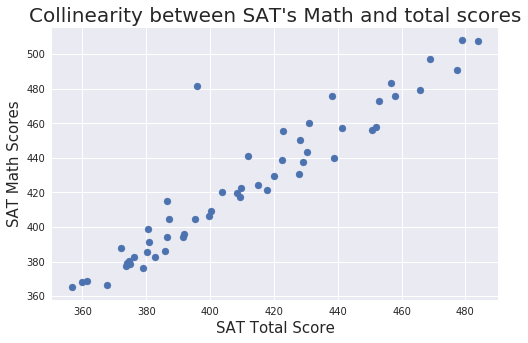

In [102]:
fig = pl.figure(figsize=(8,5)) 
ax = fig.add_subplot(111)

plot = ax.scatter(all_data.SATall, all_data.SATmath)
ax.set_xlabel("SAT Total Score", size=15)
ax.set_ylabel("SAT Math Scores", size=15)
ax.set_title("Collinearity between SAT's Math and total scores", size=20)
#ax.legend()

The figure above shows the relationship between Math scores and the total scores by puma. There is a high collinearity between both variables. Such collinearity can cause overfitting if both variables are included in the regression model.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


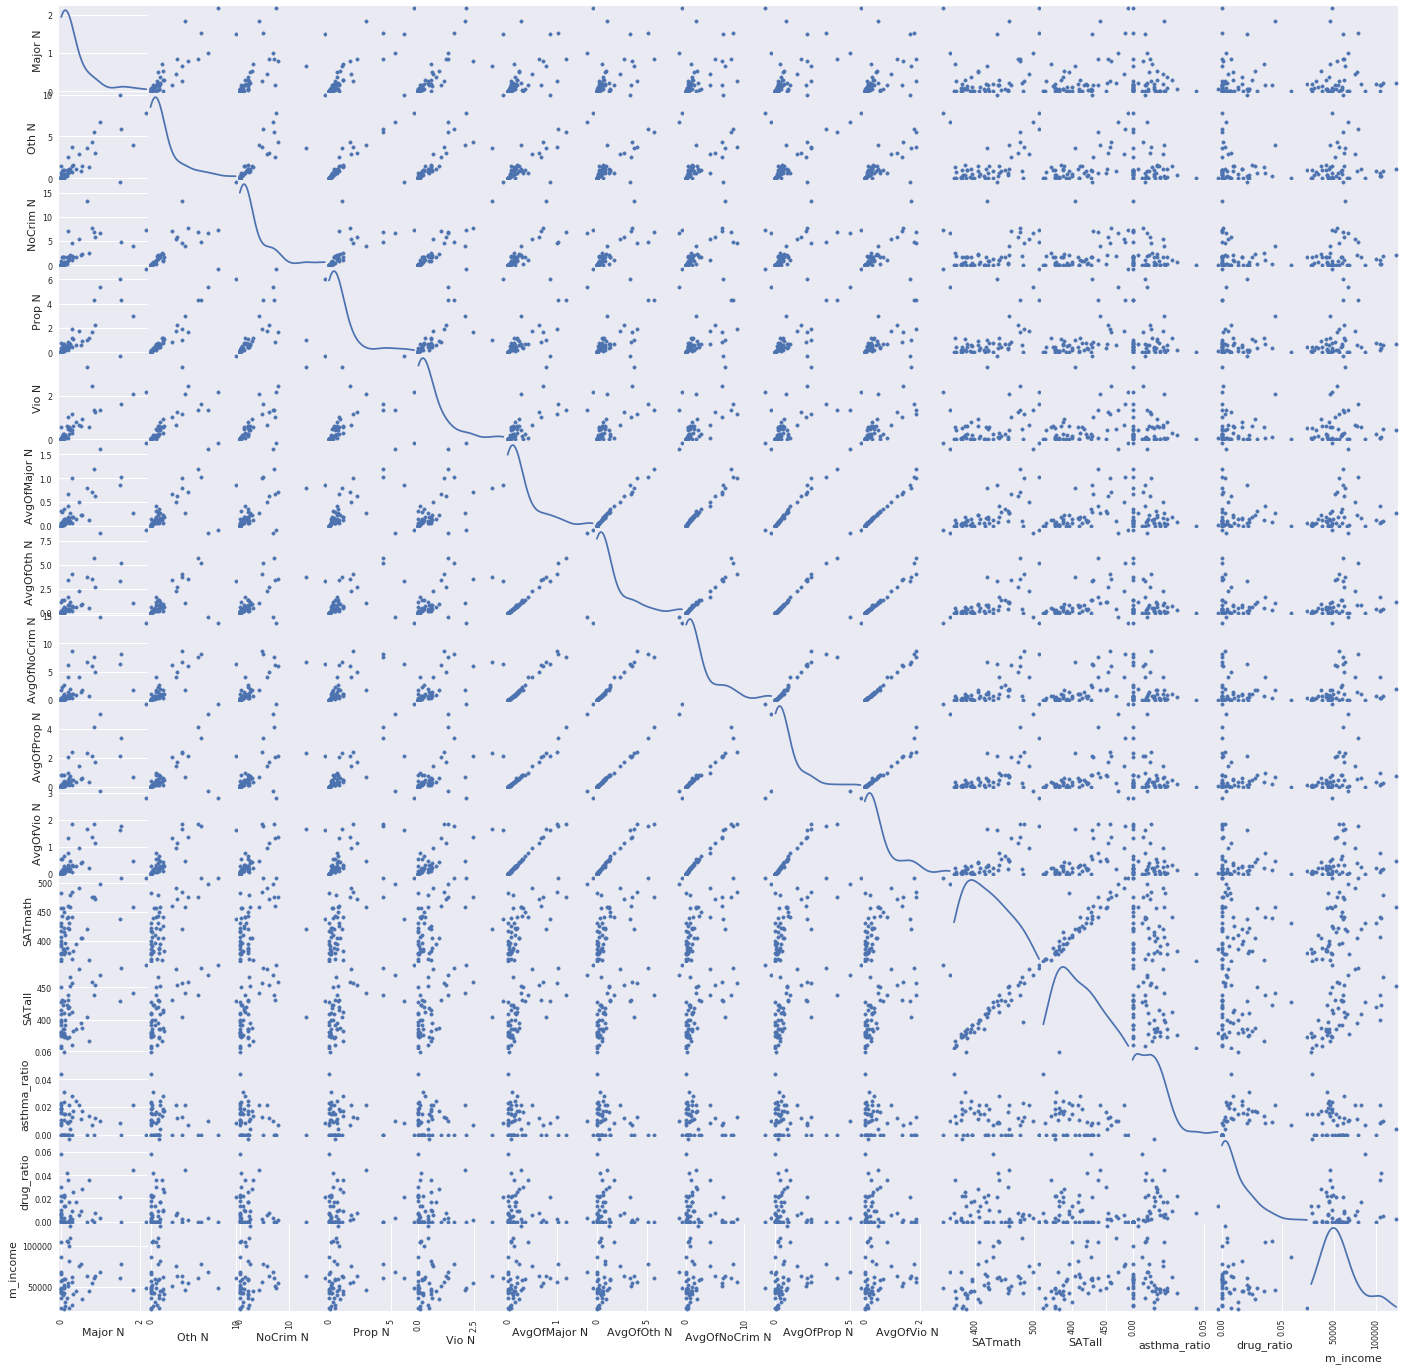

In [113]:
all_data_ = all_data.apply(pd.to_numeric)
x = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 
     'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'SATmath', 
     'SATall', 'asthma_ratio', 'drug_ratio', 'm_income']

scatter_matrix = pd.scatter_matrix(all_data_[x], alpha=1, figsize=(24, 24), diagonal='kde')

The figure above shows the correlation of all features against each other. A strong correlation can be seen between the average crime types against each other, as well as between SAT features. These features can result in a collinearity issue in the regression model. On the other hand, There is a high variance between SAT scores and median household income.

Text(0.5,1,'SAT scores & avg. # of non-criminal crimes')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


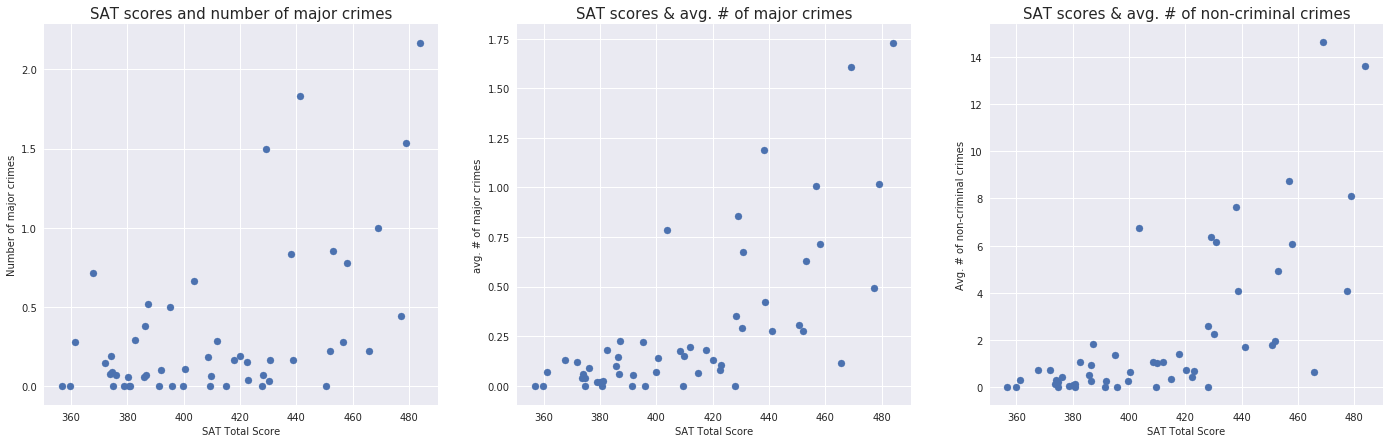

In [160]:
fig = pl.figure(figsize=(24,7)) 

ax = fig.add_subplot(131)
plot = ax.scatter(all_data.SATall, all_data['Major N'])
ax.set_xlabel("SAT Total Score", size=10)
ax.set_ylabel("Number of major crimes", size=10)
ax.set_title("SAT scores and number of major crimes", size=15)
#ax.legend()


ax = fig.add_subplot(132)
plot = ax.scatter(all_data.SATall, all_data['AvgOfMajor N'])
ax.set_xlabel("SAT Total Score", size=10)
ax.set_ylabel("avg. # of major crimes", size=10)
ax.set_title("SAT scores & avg. # of major crimes", size=15)
#ax.legend()


ax = fig.add_subplot(133)
plot = ax.scatter(all_data.SATall, all_data['AvgOfNoCrim N'])
ax.set_xlabel("SAT Total Score", size=10)
ax.set_ylabel("Avg. # of non-criminal crimes", size=10)
ax.set_title("SAT scores & avg. # of non-criminal crimes", size=15)
#ax.legend()

The plots above show a weak positive correlation between SAT scores and the number of crimes or non-criminal incidents.

In [114]:
# trying standardized data for future use
all_data_ = all_data.apply(pd.to_numeric)
all_data_s = (all_data_ - all_data_.mean()) / all_data_.std()
all_data_s.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthma_ratio,drug_ratio,m_income
0,-1.600769,-0.612280,-0.350401,-0.201584,-0.367783,-0.533562,-0.014660,0.002246,-0.001790,-0.025604,0.022547,0.466004,0.573975,-0.990847,-0.754844,0.034755
1,-1.593998,-0.674213,-0.725693,-0.698579,-0.657399,-0.713095,-0.731422,-0.665156,-0.669224,-0.664345,-0.730662,-1.129407,-1.048622,0.578330,0.601107,-0.443374
2,-1.587228,-0.674213,-0.725693,-0.698579,-0.657399,-0.713095,-0.731422,-0.665156,-0.669224,-0.664345,-0.730662,-0.739357,-0.562648,-0.990847,-0.754844,-0.041041
3,-1.580457,-0.674213,-0.037658,-0.426626,-0.156777,-0.035999,-0.577186,-0.545032,-0.567047,-0.537663,-0.581392,-0.000129,0.125102,0.545864,-0.137522,-0.422659
4,-1.573687,-0.281180,-0.255242,-0.206704,-0.371496,-0.120636,-0.586322,-0.554697,-0.572570,-0.548443,-0.591379,-1.115625,-1.068236,0.240145,3.670192,-1.441145


Text(0.5,1,'SAT scores & drug ratio')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


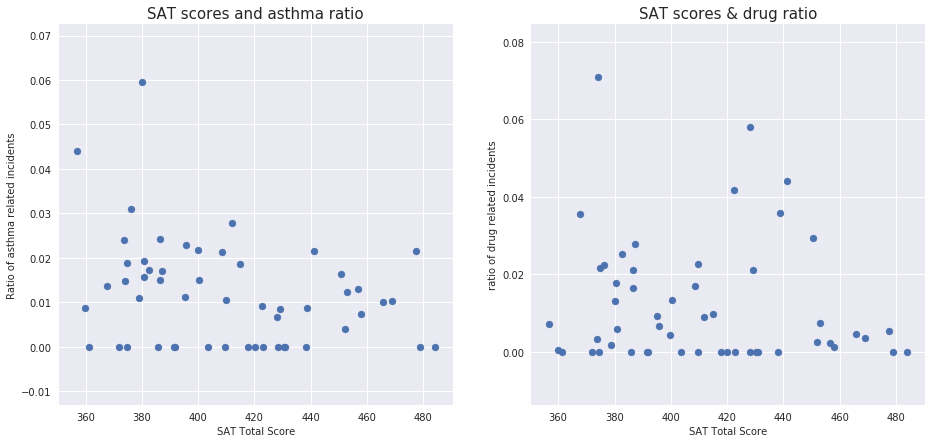

In [116]:
fig = pl.figure(figsize=(24,7)) 

ax = fig.add_subplot(131)
plot = ax.scatter(all_data.SATall, all_data['asthma_ratio'])
ax.set_xlabel("SAT Total Score", size=10)
ax.set_ylabel("Ratio of asthma related incidents", size=10)
ax.set_title("SAT scores and asthma ratio", size=15)
#ax.legend()


ax = fig.add_subplot(132)
plot = ax.scatter(all_data.SATall, all_data['drug_ratio'])
ax.set_xlabel("SAT Total Score", size=10)
ax.set_ylabel("ratio of drug related incidents", size=10)
ax.set_title("SAT scores & drug ratio", size=15)
#ax.legend()

The figure above shows the correlation between asthma and drug incidents ratio by PUMA. Both features are uncorrelated and are highly covariate. Such covariance can make the model hard to fit.

Text(0.5,1,'Income and SAT scores')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


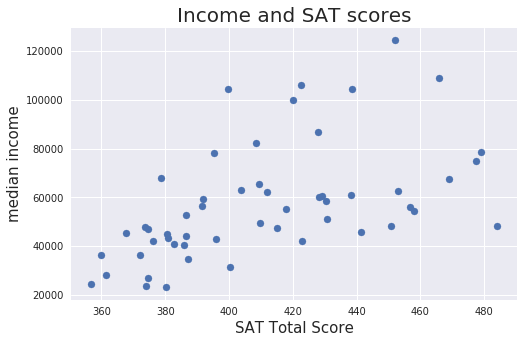

In [117]:
fig = pl.figure(figsize=(8,5)) 
ax = fig.add_subplot(111)

plot = ax.scatter(all_data.SATall, all_data.m_income)
ax.set_xlabel("SAT Total Score", size=15)
ax.set_ylabel("median income", size=15)
ax.set_title("Income and SAT scores", size=20)
#ax.legend()

The plot above shows the correlation between SAT score and median household income. There is high variance between both features, which will make the model harder to fit during regression.

### Extra Credit

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


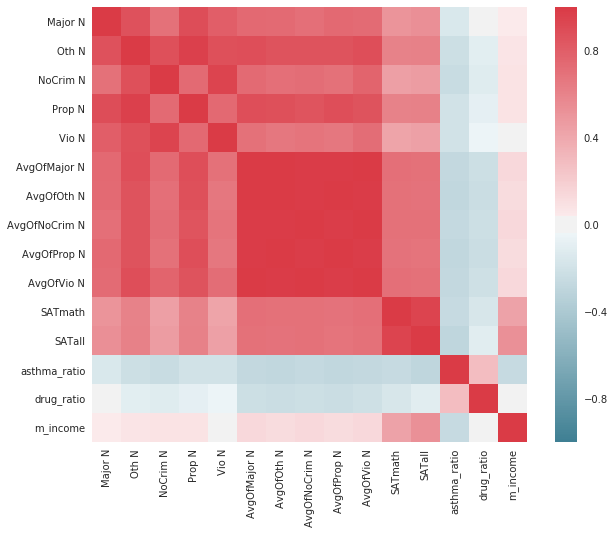

In [118]:
import seaborn as sns

x = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 
     'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'SATmath', 
     'SATall', 'asthma_ratio', 'drug_ratio', 'm_income']

f, ax = pl.subplots(figsize=(10, 8))
corr = all_data[x].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

The matrix result confirms the scatter matrix findings. The highest positive correlation (above 0.8) exist between average crime data types. An intermediate positive correlation (between o.4 and 0.8) exists between SAT scores and the average crime data types. Moreover, it exists between the total SAT score and the median income. A weak negative correlation (less than -4) exists between SAT scores and asthma/ drug incidents ratios.

# 7 Mapping (10 points)

In [119]:
gdf_all_ = puma.merge(all_data, left_on='puma', right_on='puma', how='left')
gdf_all_.crs
gdf_all_.head()


,puma,shape_area,shape_leng,geometry,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthma_ratio,drug_ratio,m_income
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,0.030303,0.818182,1.696970,0.454545,0.151515,0.288788,1.321515,2.244242,0.813939,0.544242,443.363636,430.363636,0.000000,0.000000,58409.0
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.018882,0.021711,47168.0
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000,0.000000,0.000000,56627.0
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",0.000000,1.500000,0.928571,0.785714,0.571429,0.062143,0.237857,0.343571,0.161429,0.107857,424.428571,414.976190,0.018491,0.009884,47655.0
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,2.166667,7.833333,7.333333,6.833333,2.166667,1.726667,8.568333,13.605000,5.700000,2.811667,507.500000,484.000000,0.000000,0.000000,48169.0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


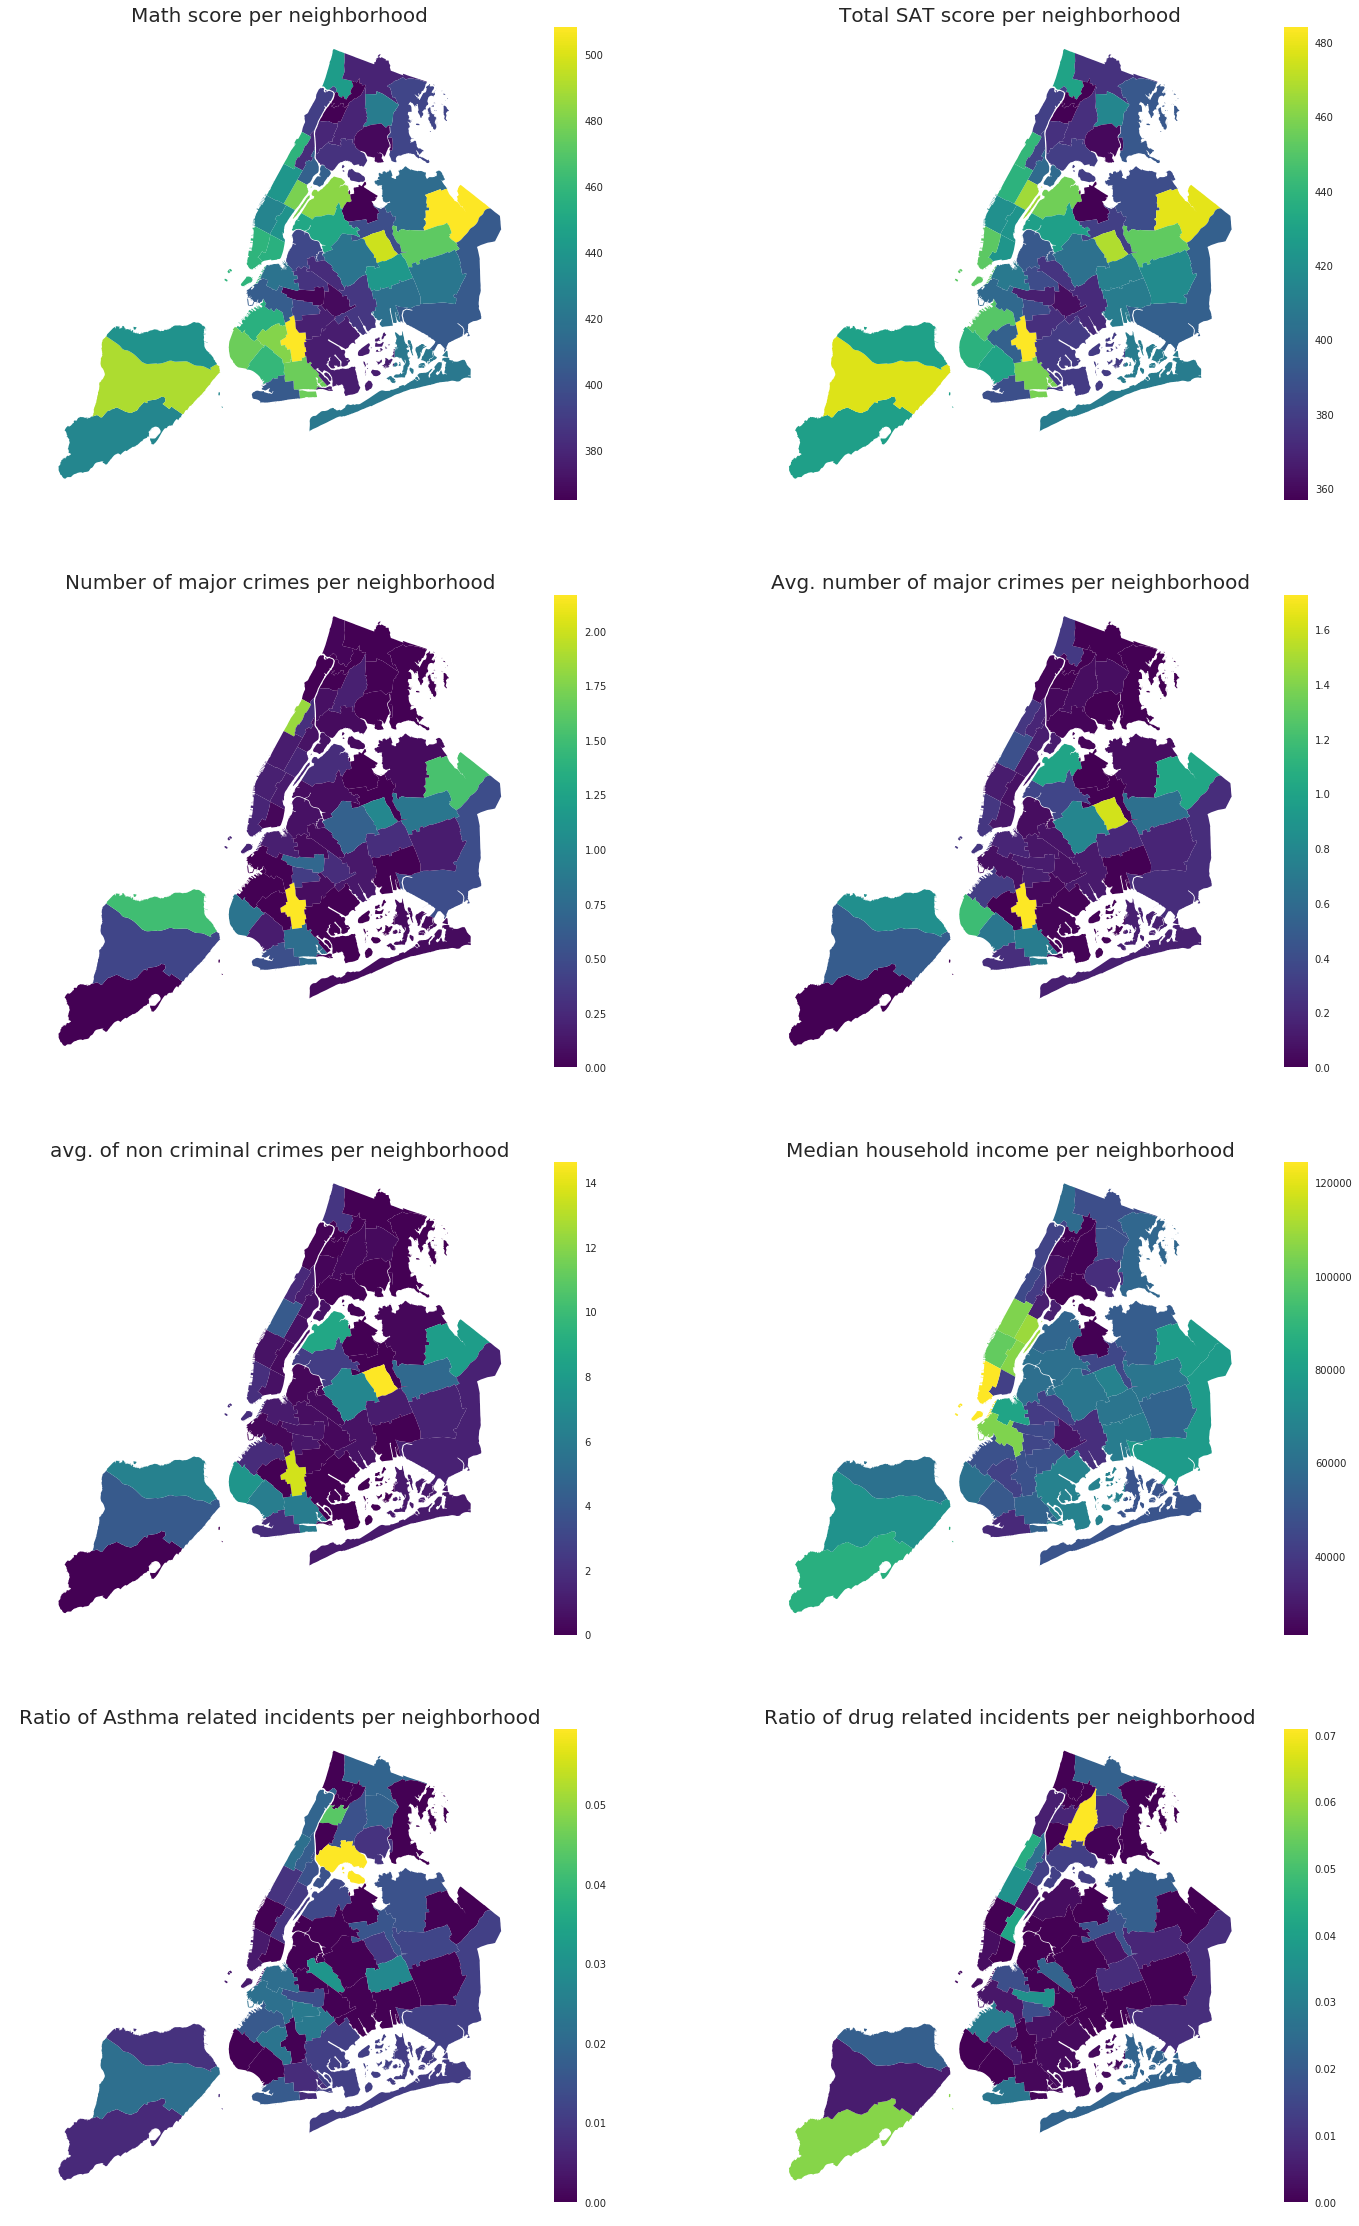

In [120]:
fig = pl.figure(figsize=(24,40)) 

ax = fig.add_subplot(421)

gdf_all_.plot(ax=ax, column = 'SATmath', cmap='viridis', legend=True, lw=0.4)
ax.set_title('Math score per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

ax = fig.add_subplot(422)
gdf_all_.plot(ax=ax, column = 'SATall', cmap='viridis', legend=True, lw=0.4)
ax.set_title('Total SAT score per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

ax = fig.add_subplot(423)

gdf_all_.plot(ax=ax, column = 'Major N', cmap='viridis', legend=True, lw=0.4)
ax.set_title('Number of major crimes per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

ax = fig.add_subplot(424)
gdf_all_.plot(ax=ax, column = 'AvgOfMajor N', cmap='viridis', legend=True, lw=0.4)
ax.set_title('Avg. number of major crimes per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

ax = fig.add_subplot(425)
gdf_all_.plot(ax=ax, column = 'AvgOfNoCrim N', cmap='viridis', legend=True, lw=0.4)
ax.set_title('avg. of non criminal crimes per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

ax = fig.add_subplot(426)

gdf_all_.plot(ax=ax, column = 'm_income', cmap='viridis', legend=True, lw=0.4)
ax.set_title('Median household income per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

ax = fig.add_subplot(427)
gdf_all_.plot(ax=ax, column = 'asthma_ratio', cmap='viridis', legend=True, lw=0.4)
ax.set_title('Ratio of Asthma related incidents per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

ax = fig.add_subplot(428)
gdf_all_.plot(ax=ax, column = 'drug_ratio', cmap='viridis', legend=True, lw=0.4)
ax.set_title('Ratio of drug related incidents per neighborhood',size=20)
ax.axis('off')
ax.legend(loc='upper left')

The maps above show the change of each feature by PUMA. Again.there no clear correlation between the different features and SAT scores. For example, PUMAs in the Bronx have one of the lowest SAT scores, lowest school crime incidents, lowest median income and highest Asthma and drug incidents. On the other hand, Some Queens PUMAs have the highest SAT scores, moderate crime incidents, moderate income, and lowest asthma/drug incidents.

# 8 start with linear modeling (10 points)

In [121]:
# linear regression using standardized data
# organizing variables

x_crime = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 
             'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N']

x_cr_dis = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 
             'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 
            'asthma_ratio', 'drug_ratio']

x_all = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 
         'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 
         'asthma_ratio', 'drug_ratio','m_income']

In [122]:
model_cr = st.OLS(exog=st.add_constant(all_data_s[x_crime]), endog=all_data_s['SATall']).fit()
model_cr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     6.467
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.09e-06
Time:                        22:01:49   Log-Likelihood:                -49.999
No. Observations:                  53   AIC:                             122.0
Df Residuals:                      42   BIC:                             143.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const         -2.606e-15      0.096  -2.72e-14      1.000        -0.194     0.194
Major N           0.8426      0.448      1.879      0.067        -0.062     1.747
Oth N             2.1609      1.344      1.608      0.115        -0.551     4.872
NoCrim N         -0.2319      0.441     -0.526      0.602        -1.121     0.657
Prop N           -2.0553      1.145     -1.795      0.080        -4.367     0.256
Vio N            -1.1572      0.699     -1.655      0.105        -2.568     0.254
AvgOfMajor N      2.1167      3.269      0.648      0.521        -4.480     8.713
AvgOfOth N        2.2829      6.417      0.356      0.724       -10.666    15.232
AvgOfNoCrim N    -2.9329      2.435     -1.204      0.235        -7.848     1.982
AvgOfProp N      -2.7410      5.495     -0.499      0.621       -13.830     8.348
AvgOfVio N        2.2158      2.876      0.770      0.445        -3.589     8.020
==============================================================================
Omnibus:                        7.226   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                6.235
Skew:                           0.750   Prob(JB):                       0.0443
Kurtosis:                       3.758   Cond. No.                         281.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model above doesn't seem to  be a good fit. The R square is 0.6, which is a moderate value. The constant coefficient is high. Many of the independent features have -ve coffecients and none of them has a significant p-value (below 0.05).

Text(0.5,1,'Predicted vs actual score (crime data only)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


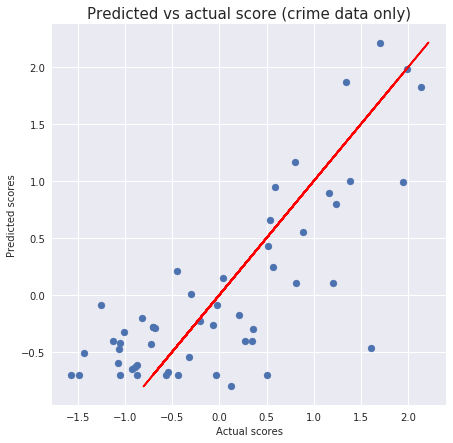

In [129]:
all_data_s['SATcr_pred'] = model_cr.predict()

data_cr = all_data_s[['SATall','SATcr_pred']]
data_cr.head()

fig = pl.figure(figsize=(24,7)) 

ax = fig.add_subplot(131)
plot = ax.scatter(data_cr.SATall, data_cr['SATcr_pred'])
plot = ax.plot(data_cr.SATcr_pred, data_cr['SATcr_pred'], 'r')
ax.set_xlabel("Actual scores", size=10)
ax.set_ylabel("Predicted scores", size=10)
ax.set_title("Predicted vs actual score (crime data only)", size=15)
#ax.legend()

The plot above shows the actual SAT scores against the fitted model of predicted scores. As expected, alot of data points are far from the fitted line and the line does not pass through alot of data points. This means that the model is too generic and won't be able to predict accurately.

In [130]:
model_crdis = st.OLS(exog=st.add_constant(all_data_s[x_cr_dis]), endog=all_data_s['SATall']).fit()
model_crdis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     5.555
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.78e-05
Time:                        22:15:10   Log-Likelihood:                -48.709
No. Observations:                  53   AIC:                             123.4
Df Residuals:                      40   BIC:                             149.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const         -2.606e-15      0.096  -2.72e-14      1.000        -0.194     0.194
Major N           0.8114      0.458      1.771      0.084        -0.115     1.738
Oth N             2.1624      1.347      1.605      0.116        -0.560     4.885
NoCrim N         -0.2999      0.445     -0.674      0.504        -1.200     0.600
Prop N           -2.0021      1.147     -1.745      0.089        -4.321     0.317
Vio N            -1.1080      0.703     -1.576      0.123        -2.529     0.313
AvgOfMajor N      2.1332      3.305      0.645      0.522        -4.547     8.813
AvgOfOth N        2.6240      6.515      0.403      0.689       -10.544    15.792
AvgOfNoCrim N    -3.0087      2.449     -1.229      0.226        -7.958     1.941
AvgOfProp N      -3.0707      5.557     -0.553      0.584       -14.303     8.161
AvgOfVio N        2.2194      2.919      0.760      0.451        -3.680     8.119
asthma_ratio     -0.1489      0.106     -1.410      0.166        -0.362     0.064
drug_ratio        0.0391      0.111      0.353      0.726        -0.185     0.263
==============================================================================
Omnibus:                        7.251   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                6.392
Skew:                           0.689   Prob(JB):                       0.0409
Kurtosis:                       3.998   Cond. No.                         286.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression model above uses both crime and hospital data. The model has slightly improved. The R2 is now 0.625, but other characteristics did not improve. All p values are insignificant.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,1,'Predicted vs actual score (crime + hospital data)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


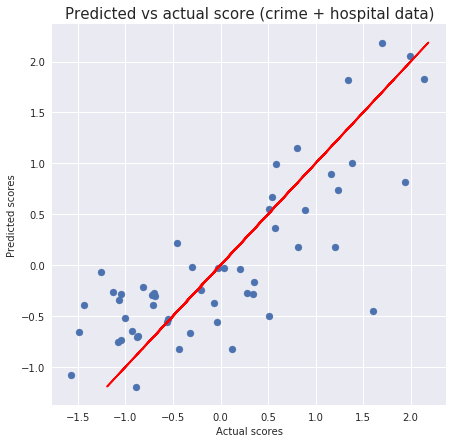

In [133]:
data_cr['SATcrdis_pred'] = model_crdis.predict()
data_cr.head()

fig = pl.figure(figsize=(24,7)) 

ax = fig.add_subplot(131)
plot = ax.scatter(data_cr.SATall, data_cr['SATcrdis_pred'])
plot = ax.plot(data_cr.SATcrdis_pred, data_cr['SATcrdis_pred'], 'r')
ax.set_xlabel("Actual scores", size=10)
ax.set_ylabel("Predicted scores", size=10)
ax.set_title("Predicted vs actual score (crime + hospital data)", size=15)
#ax.legend()

The plot above shows the fitted line of the predicited value in comparison to the actual values of SAT scores. The line passes through some data points, which is progress. However, the distances between most points and the line are still too large.

In [134]:
model_all = st.OLS(exog=st.add_constant(all_data_s[x_all]), endog=all_data_s['SATall']).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     11.82
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           9.15e-10
Time:                        22:28:11   Log-Likelihood:                -32.371
No. Observations:                  53   AIC:                             92.74
Df Residuals:                      39   BIC:                             120.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const         -2.606e-15      0.071  -3.65e-14      1.000        -0.144     0.144
Major N           0.6814      0.342      1.994      0.053        -0.010     1.373
Oth N             2.2929      1.003      2.287      0.028         0.265     4.321
NoCrim N         -0.5032      0.333     -1.511      0.139        -1.177     0.170
Prop N           -2.0075      0.854     -2.351      0.024        -3.734    -0.281
Vio N            -0.8073      0.526     -1.535      0.133        -1.871     0.256
AvgOfMajor N      2.0297      2.459      0.825      0.414        -2.945     7.004
AvgOfOth N        4.2685      4.856      0.879      0.385        -5.554    14.091
AvgOfNoCrim N    -3.3660      1.823     -1.846      0.072        -7.054     0.322
AvgOfProp N      -3.8979      4.138     -0.942      0.352       -12.267     4.471
AvgOfVio N        1.7500      2.173      0.805      0.426        -2.646     6.146
asthma_ratio     -0.0376      0.081     -0.465      0.644        -0.201     0.126
drug_ratio        0.0129      0.082      0.157      0.876        -0.154     0.180
m_income          0.4444      0.077      5.766      0.000         0.289     0.600
==============================================================================
Omnibus:                        1.263   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                1.191
Skew:                           0.347   Prob(JB):                        0.551
Kurtosis:                       2.762   Cond. No.                         287.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adding income data to the regression model has improved it alot. Our new r2 is 0.798,which is high. Three independent variables are significant: median income, number of property related crimes, and the number of other unclassified crimes 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,1,'Predicted vs actual score (all data)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


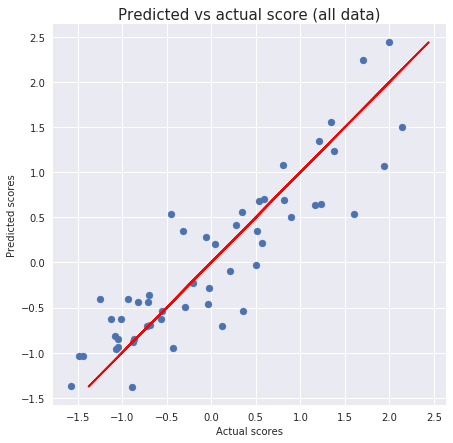

In [136]:
data_cr['SATall_pred'] = model_all.predict()
data_cr.head()

fig = pl.figure(figsize=(24,7)) 

ax = fig.add_subplot(131)
plot = ax.scatter(data_cr.SATall, data_cr['SATall_pred'])
plot = ax.plot(data_cr.SATall_pred, data_cr['SATall_pred'], 'r')
ax.set_xlabel("Actual scores", size=10)
ax.set_ylabel("Predicted scores", size=10)
ax.set_title("Predicted vs actual score (all data)", size=15)
#ax.legend()

Most points are now close to the predicted values (the fitted line). This may suggest that the model is performing better. however, it could be a sign that the model is overfitting. Especially because the income data showed large covariance during the collinearity check.

# 9 compare the linear models (10 points)

In [139]:
#defining a chi square function

def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1


In [140]:
dof_cr = min(len(data_cr.SATall) - np.isnan(data_cr.SATall).sum(), 
         len(data_cr.SATcr_pred) - np.isnan(data_cr.SATcr_pred).sum()) - (len(x_crime)+1)
print ("degrees of freedom of crime data model:" , dof_cr)

dof_crdis = min(len(data_cr.SATall) - np.isnan(data_cr.SATall).sum(), 
         len(data_cr.SATcrdis_pred) - np.isnan(data_cr.SATcrdis_pred).sum()) - (len(x_cr_dis)+1)
print ("degrees of freedom of crime + discharge data model:" , dof_crdis)

dof_all = min(len(data_cr.SATall) - np.isnan(data_cr.SATall).sum(), 
         len(data_cr.SATall_pred) - np.isnan(data_cr.SATall_pred).sum()) - (len(x_all)+1)
print ("degrees of freedom of crime + discharge + income data model:" , dof_all)

degrees of freedom of crime data model: 42
degrees of freedom of crime + discharge data model: 40
degrees of freedom of crime + discharge + income data model: 39


In [141]:
print ("Risiduals of actual vs predicted SAT scores in crime data model (no errors included): %.2f"%\
       (chi2(data_cr.SATall, data_cr.SATcr_pred) / float(dof_cr)))

print ("Risiduals of actual vs predicted SAT scores in crime + discharge data model (no errors included): %.2f"%\
       (chi2(data_cr.SATall, data_cr.SATcrdis_pred) / float(dof_crdis)))

print ("Risiduals of actual vs predicted SAT scores in crime + discharge + income data model (no errors included): %.2f"%\
       (chi2(data_cr.SATall, data_cr.SATall_pred) / float(dof_all)))

Risiduals of actual vs predicted SAT scores in crime data model (no errors included): 0.49
Risiduals of actual vs predicted SAT scores in crime + discharge data model (no errors included): 0.49
Risiduals of actual vs predicted SAT scores in crime + discharge + income data model (no errors included): 0.27


CHi squared test results confirm our previous finding. The model generated by fitting actual vs predicted sat score using all data (crime, hospital discharge, and income data) is passing through the majority of the data much more closely than the model generated using crime or crime and hospital data alone. Because of that the model resulting from all data is preferible: it is less sensitive to outliers and and better describes the typical behavior.

# Extra credit: if you did the income model, based on this result is there another multilinear model you would like to run?

Since Income feature is highly covariate, it might be a good idea to use ridge regression

# 10 random forest regression on school-related data only (10 points)

In [143]:
#transforming endog data into binary
all_data_s["SATall_b"] = (all_data_s.SATall > all_data_s.SATall.mean()).astype(int)
all_data_s.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthma_ratio,drug_ratio,m_income,SATcr_pred,SATall_b
0,-1.600769,-0.612280,-0.350401,-0.201584,-0.367783,-0.533562,-0.014660,0.002246,-0.001790,-0.025604,0.022547,0.466004,0.573975,-0.990847,-0.754844,0.034755,0.246456,1
1,-1.593998,-0.674213,-0.725693,-0.698579,-0.657399,-0.713095,-0.731422,-0.665156,-0.669224,-0.664345,-0.730662,-1.129407,-1.048622,0.578330,0.601107,-0.443374,-0.699937,0
2,-1.587228,-0.674213,-0.725693,-0.698579,-0.657399,-0.713095,-0.731422,-0.665156,-0.669224,-0.664345,-0.730662,-0.739357,-0.562648,-0.990847,-0.754844,-0.041041,-0.699937,0
3,-1.580457,-0.674213,-0.037658,-0.426626,-0.156777,-0.035999,-0.577186,-0.545032,-0.567047,-0.537663,-0.581392,-0.000129,0.125102,0.545864,-0.137522,-0.422659,-0.804100,1
4,-1.573687,-0.281180,-0.255242,-0.206704,-0.371496,-0.120636,-0.586322,-0.554697,-0.572570,-0.548443,-0.591379,-1.115625,-1.068236,0.240145,3.670192,-1.441145,-0.472653,0


### 10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features (5 points)

In [144]:
Xcr_train, Xcr_test, ycr_train, ycr_test = train_test_split(all_data_s[x_crime], all_data_s.SATall, test_size=0.3)

In [145]:
regr_cr = rfr(max_depth=3, random_state=0, n_estimators=10).fit(Xcr_train, ycr_train)
regr_cr


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [146]:
ycr_pred = regr_cr.predict(Xcr_test)
ycr_pred#_ = np.around(ycr_pred).astype(int)

array([-0.64201634,  0.03243502,  0.40246936,  0.97641261,  0.83758275,
       -0.02200732,  0.0348943 ,  0.92419165,  0.95481575,  0.47575157,
        0.62239092,  0.32211777, -0.62442067,  0.02008646,  1.57997048,
       -0.13436732])

In [147]:
print(regr_cr.score(Xcr_train, ycr_train))
print(regr_cr.score(Xcr_test, ycr_test))

0.78144003042
-0.132712360731


There is a large difference between the model's score for the training set and the testing set. The model probably suffers from overfitting.

### 10.2 measure the feature importance of the features in this model to select the 3 most predictive features (5 points)

In [148]:
importances_cr = regr_cr.feature_importances_
importances_cr

array([ 0.10909126,  0.00400412,  0.16905754,  0.00175278,  0.03737028,
        0.10186649,  0.1667871 ,  0.19534727,  0.11215091,  0.10257224])

Feature ranking:
1. feature 7 (0.195347)
2. feature 2 (0.169058)
3. feature 6 (0.166787)
4. feature 8 (0.112151)
5. feature 0 (0.109091)
6. feature 9 (0.102572)
7. feature 5 (0.101866)
8. feature 4 (0.037370)
9. feature 1 (0.004004)
10. feature 3 (0.001753)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


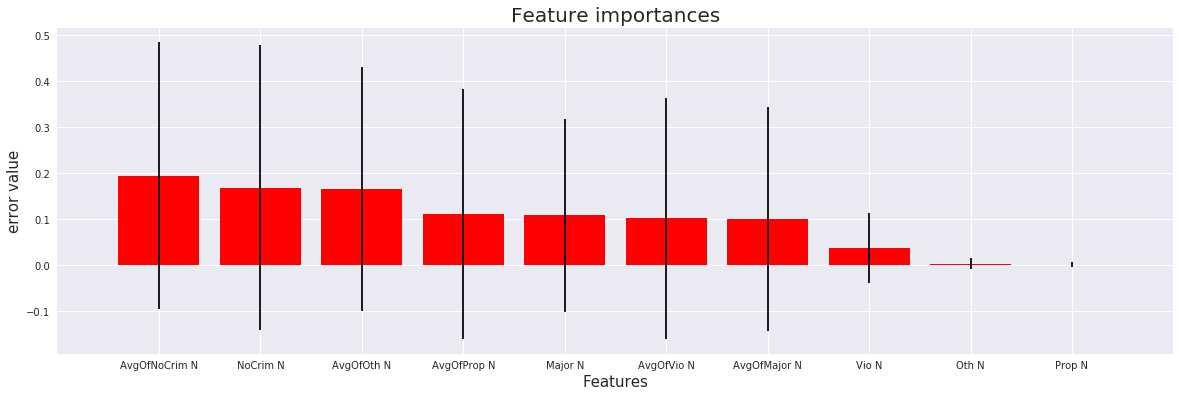

In [150]:
std = np.std([tree.feature_importances_ for tree in regr_cr.estimators_],
             axis=0)
indices = np.argsort(importances_cr)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xcr_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances_cr[indices[f]]))

# Plot the feature importances of the forest
pl.figure(figsize=(20,6))
pl.title("Feature importances", size=20)
pl.bar(range(Xcr_test.shape[1]), importances_cr[indices],
       color="r", yerr=std[indices], align="center")
pl.xticks(range(Xcr_test.shape[1]), all_data_s[x_crime].columns[indices])
pl.xlim([-1, Xcr_test.shape[1]])
pl.xlabel('Features', size=15)
pl.ylabel('error value', size=15)
pl.show()

The three most predictive features are mumber of property related crimes, average number of other crimes, average number of violent crimes. These are the feature whose change can cause an error in the model higher than the original error. As shown in the graph above, the difference in importance errors isn't much between the first three. This means that the model isn't very sensitive to their change compared to each other.

# 11 random forest with crime and medical (and income) features

In [151]:
# selecting exog values

x_imp = ['Prop N', 'AvgOfOth N', 'AvgOfVio N', 
         'asthma_ratio', 'drug_ratio','m_income']

In [152]:
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(all_data_s[x_imp], all_data_s.SATall, test_size=0.3)

In [153]:
regr_imp = rfr(max_depth=3, random_state=0, n_estimators=10).fit(Ximp_train, yimp_train)
regr_imp


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [154]:
yimp_pred = regr_imp.predict(Ximp_test)
yimp_pred

array([ 0.07561306,  0.0905101 , -0.72140059, -1.25529174,  0.87501039,
       -0.50939109,  0.40926343,  0.27338161,  0.870448  , -0.11968984,
        1.43342437,  1.30654483, -0.70293014, -0.91834529,  1.15866738,
       -0.95694577])

In [155]:
print(regr_imp.score(Ximp_train, yimp_train))
print(regr_imp.score(Ximp_test, yimp_test))

0.86072010575
0.688984055554


The test data scores of the model has significantly improved since the last model.

In [156]:
importances_imp = regr_imp.feature_importances_
importances_imp

array([ 0.19741703,  0.15810481,  0.143585  ,  0.08579041,  0.02737656,
        0.38772619])

Feature ranking:
1. feature 5 (0.387726)
2. feature 0 (0.197417)
3. feature 1 (0.158105)
4. feature 2 (0.143585)
5. feature 3 (0.085790)
6. feature 4 (0.027377)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


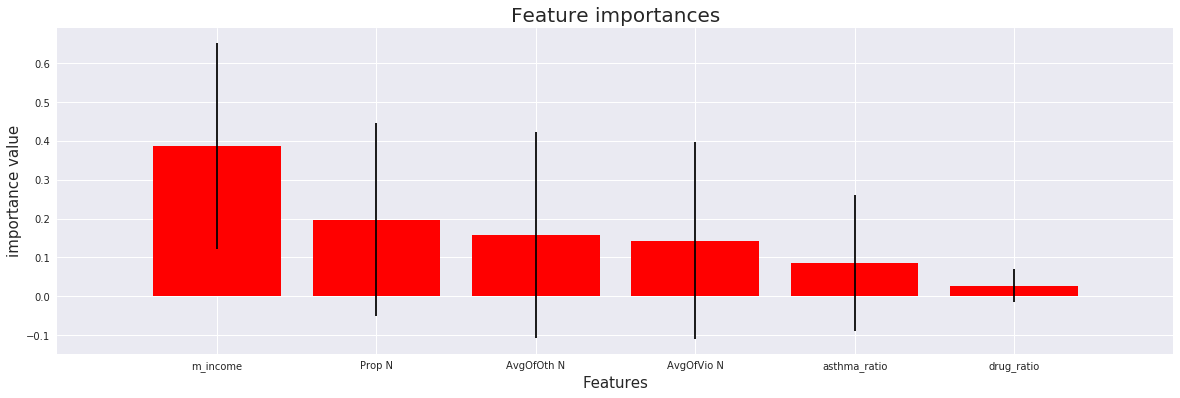

In [157]:
std_ = np.std([tree.feature_importances_ for tree in regr_imp.estimators_],
             axis=0)
indices_ = np.argsort(importances_imp)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Ximp_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_[f], importances_imp[indices_[f]]))

# Plot the feature importances of the forest
pl.figure(figsize=(20,6))
pl.title("Feature importances", size=20)
pl.bar(range(Ximp_test.shape[1]), importances_imp[indices_],
       color="r", yerr=std_[indices_], align="center")
pl.xticks(range(Ximp_test.shape[1]), all_data_s[x_imp].columns[indices_])
pl.xlim([-1, Ximp_test.shape[1]])
pl.xlabel('Features', size=15)
pl.ylabel('importance value', size=15)
pl.show()

The highest predictors are now average number of other crimes, number of property related crimes, avergae number of violent crimes and household median income. As expected, the most covariate feature has the highest error value when changed compared to other values. This suggests that the model is indeed overfitting.